# Video Classification - Evaluation and Visualization
## Big Vision Internship Assignment

This notebook covers:
1. Load trained model
2. Comprehensive evaluation on test set
3. Confusion matrix visualization
4. Per-class performance analysis
5. Sample predictions visualization

In [11]:
import sys
sys.path.append('..')

import torch
import yaml
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from utils.data_utils import create_data_loaders, load_splits
from utils.model_utils import create_model, load_checkpoint
from utils.training_utils import test
from utils.visualization_utils import (
    plot_confusion_matrix, plot_per_class_metrics,
    visualize_video_frames, plot_top_k_predictions
)

print("✅ Libraries imported!")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

✅ Libraries imported!
Device: cuda


## 1. Load Configuration and Data

In [12]:
# Load config
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Helper function to resolve paths from notebook location
def resolve_path(path_str):
    """Convert config paths (relative to project root) to notebook paths"""
    if path_str.startswith('./'):
        return str(Path('..') / path_str[2:])
    return path_str

# Load splits (resolve path from notebook location)
splits_dir = resolve_path(config['dataset']['splits_dir'])
splits = load_splits(splits_dir)
test_files = splits['test']['files']
test_labels = splits['test']['labels']
class_names = splits['class_names']

print(f"Test samples: {len(test_files)}")
print(f"Classes: {len(class_names)}")

Test samples: 105
Classes: 5


## 2. Load Trained Model

In [13]:
# Create model (without LoRA initially - will be applied during checkpoint loading if needed)
model = create_model(
    config['model']['name'],
    len(class_names),
    config['model'],
    pretrained=False
)

# Load checkpoint (resolve path and find best model)
models_dir = Path(resolve_path(config['output']['models_dir']))

# Find the best model checkpoint (look for best_model_epoch_*.pth)
best_checkpoints = sorted(models_dir.glob("best_model_epoch_*.pth"))
if best_checkpoints:
    checkpoint_path = best_checkpoints[-1]  # Use the most recent
    print(f"📂 Found best model: {checkpoint_path.name}")
else:
    # Fallback to last checkpoint
    checkpoint_path = models_dir / "last_checkpoint.pth"
    print(f"📂 Using last checkpoint: {checkpoint_path.name}")

# Load checkpoint (pass config so LoRA can be applied if needed)
model, checkpoint = load_checkpoint(
    model,
    str(checkpoint_path),
    device,
    config  # Pass config for LoRA handling
)

# Move model to device and set to eval mode
model = model.to(device)
model.eval()

print(f"✅ Model loaded from checkpoint (Epoch {checkpoint['epoch']})")
print(f"✅ Model moved to {device}")

📂 Found best model: best_model_epoch_8.pth
⚠️  Warning: Error(s) in loading state_dict for VideoMAEClassifier:
	Missing key(s) in state_dict: "model.fc_norm.weight", "model.fc_norm.bias". 
	Unexpected key(s) in state_dict: "model.videomae.layernorm.weight", "model.videomae.layernorm.bias". 
Trying non-strict loading...
✅ Model loaded from checkpoint (Epoch 8)
✅ Model moved to cuda


## 3. Comprehensive Evaluation

In [14]:
# Create test dataset and loader
from utils.data_utils import VideoDataset
from torch.utils.data import DataLoader

test_dataset = VideoDataset(
    test_files,
    test_labels,
    num_frames=config['video']['num_frames'],
    frame_size=tuple(config['video']['frame_size']),
    sampling_strategy='uniform',
    augment=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['evaluation']['batch_size'],
    shuffle=False,
    num_workers=config['training']['num_workers'],
    pin_memory=config['training']['pin_memory']
)

print(f"✅ Test loader created: {len(test_dataset)} samples, {len(test_loader)} batches")


✅ Test loader created: 105 samples, 7 batches


In [15]:
# Evaluate on test set
print("🔍 Evaluating model on test set...")
test_results = test(model, test_loader, device, class_names)

print(f"\n📊 Test Results:")
print(f"   Accuracy: {test_results['accuracy']:.4f}")
print(f"   Top-5 Accuracy: {test_results['top5_accuracy']:.4f}")
print(f"   Precision: {test_results['precision']:.4f}")
print(f"   Recall: {test_results['recall']:.4f}")
print(f"   F1-Score: {test_results['f1_score']:.4f}")

🔍 Evaluating model on test set...


Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Testing: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it]


📊 Test Results:
   Accuracy: 0.9048
   Top-5 Accuracy: 1.0000
   Precision: 0.9109
   Recall: 0.9076
   F1-Score: 0.9001


## 4. Confusion Matrix

Confusion matrix saved to ../outputs/visualizations/confusion_matrix.png


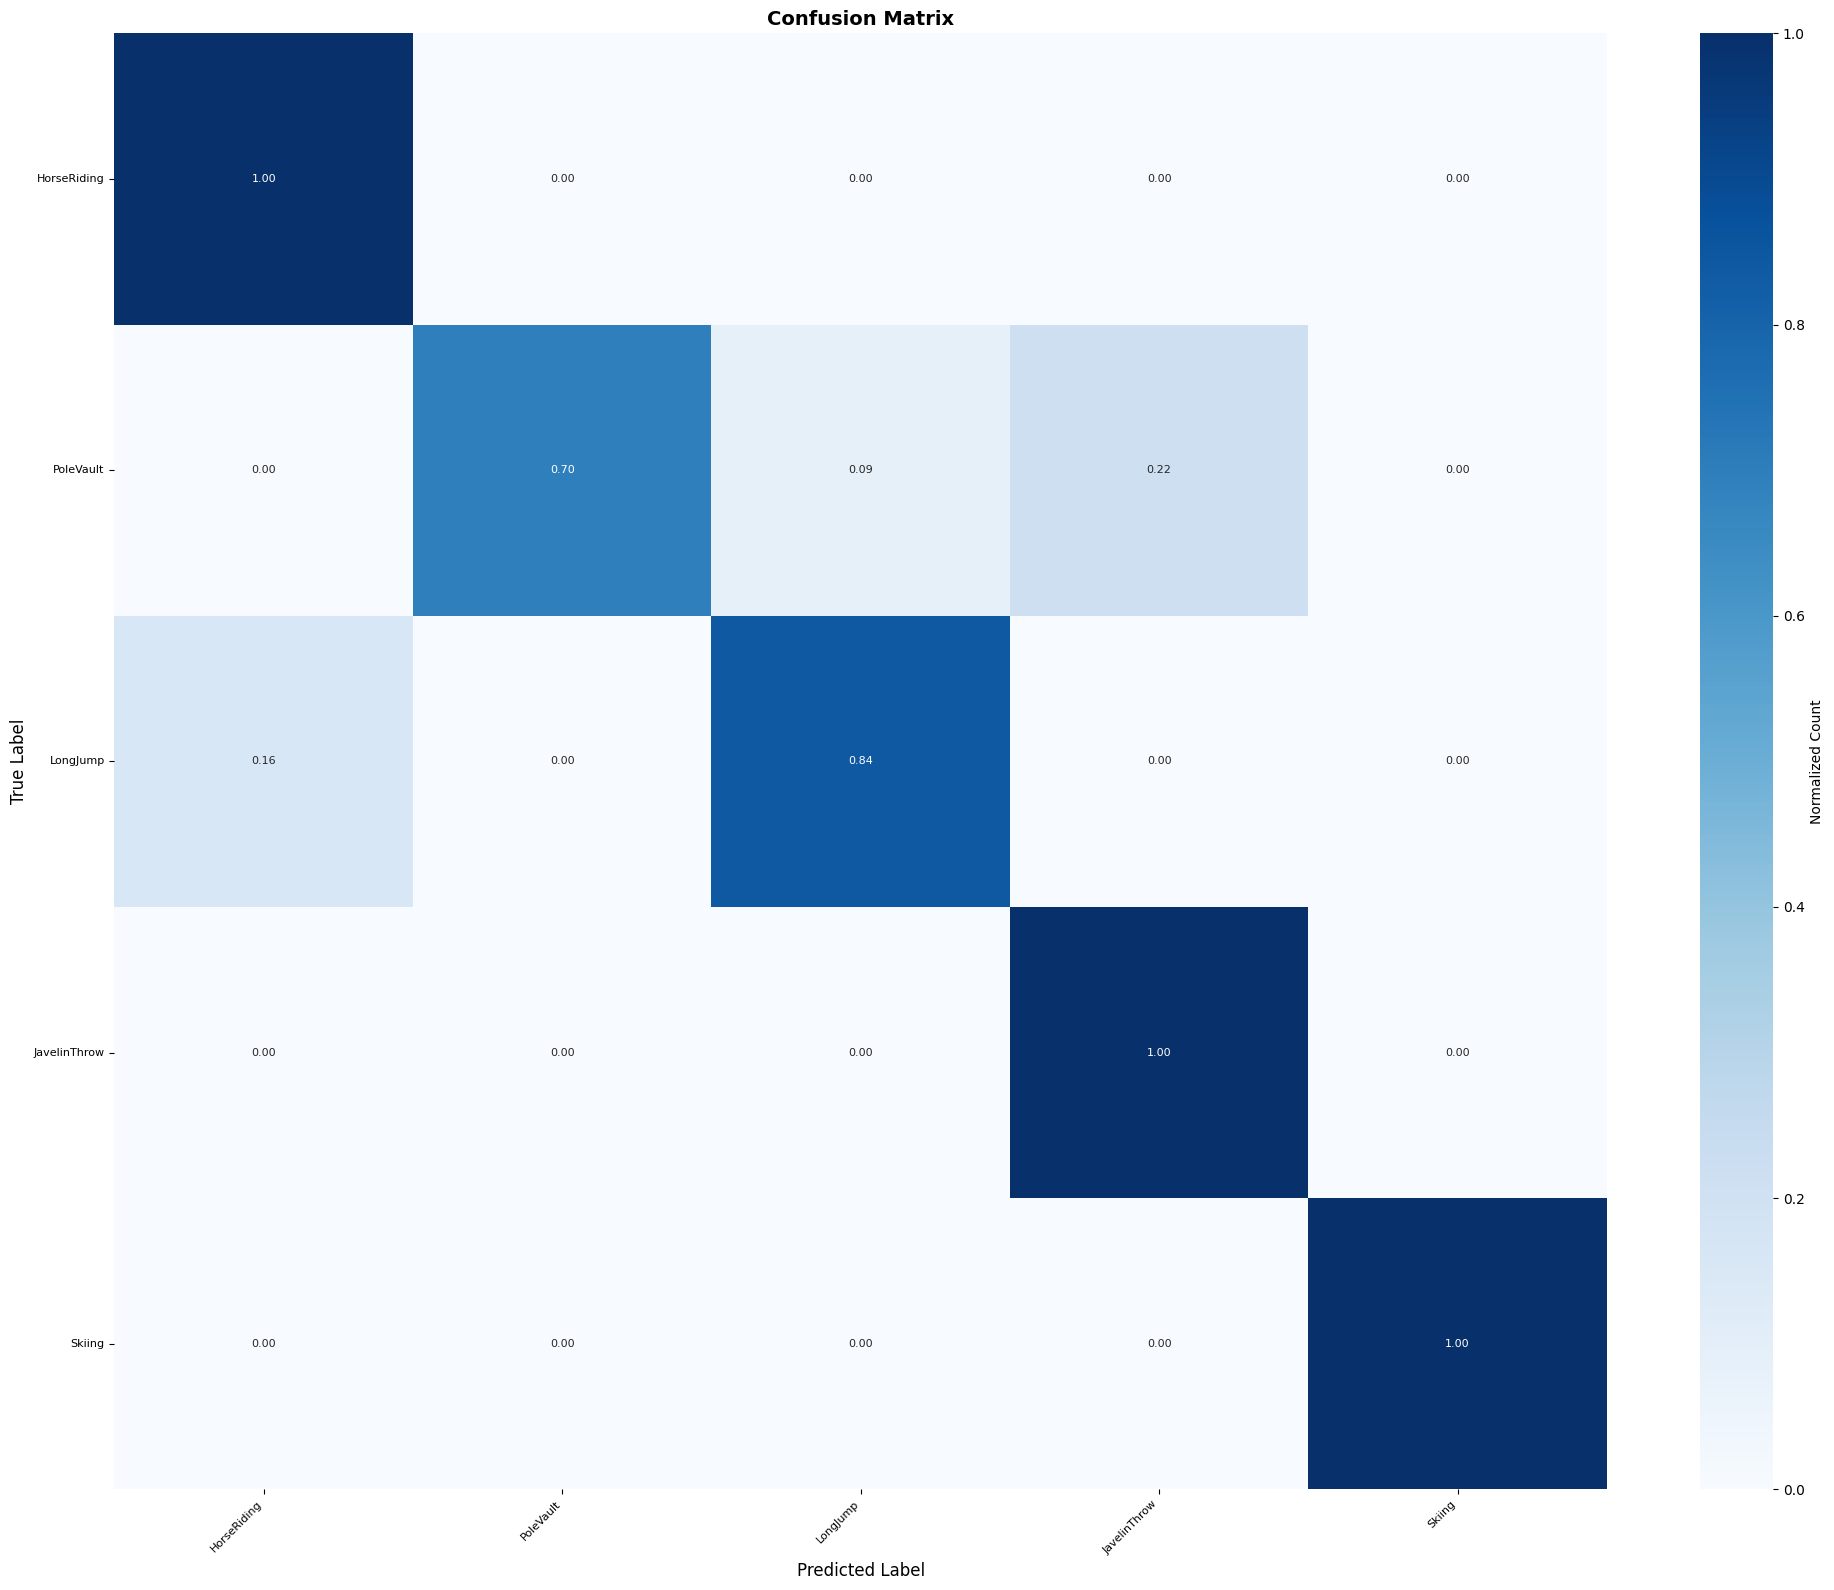

In [16]:
# Plot confusion matrix (resolve path)
viz_dir = Path(resolve_path(config['output']['visualizations_dir']))
viz_dir.mkdir(parents=True, exist_ok=True)

plot_confusion_matrix(
    test_results['confusion_matrix'],
    class_names,
    normalize=True,
    save_path=str(viz_dir / "confusion_matrix.png")
)

## 5. Per-Class Performance

Per-class metrics plot saved to ../outputs/visualizations/per_class_metrics.png


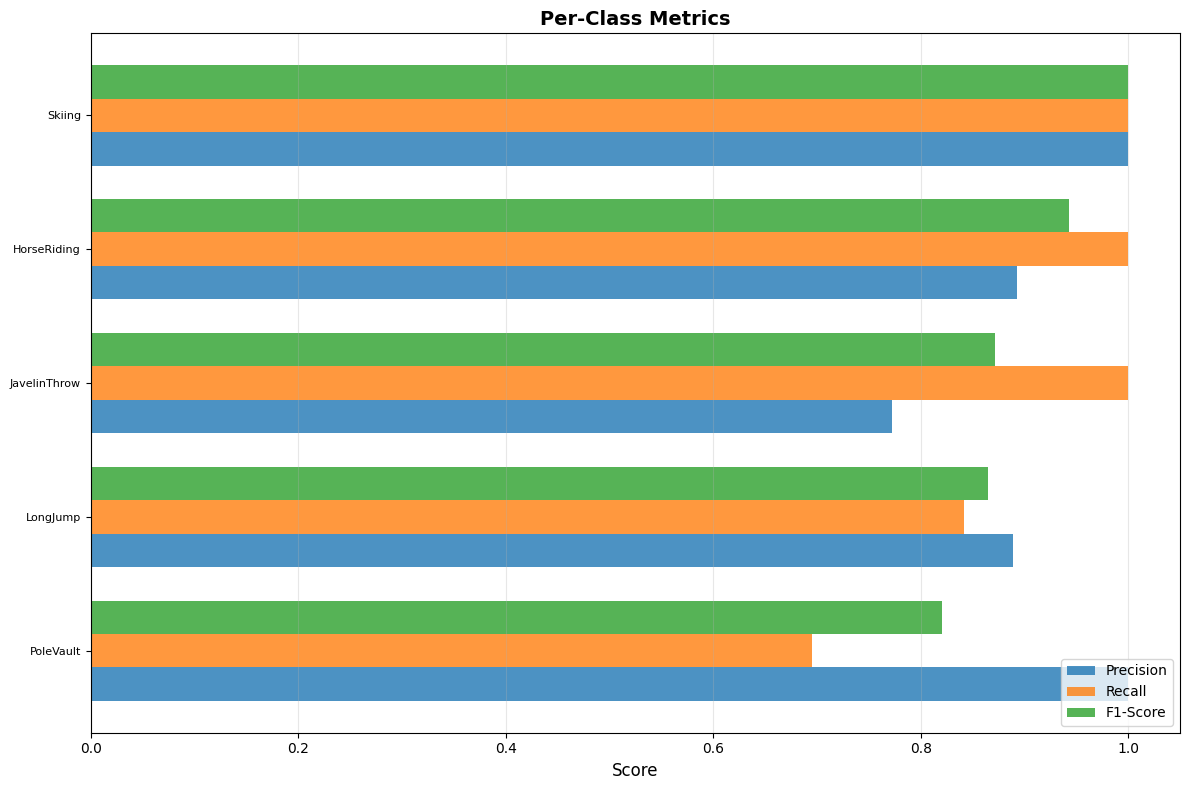

In [17]:
# Plot per-class metrics
plot_per_class_metrics(
    test_results['per_class_precision'],
    test_results['per_class_recall'],
    test_results['per_class_f1'],
    class_names,
    save_path=str(viz_dir / "per_class_metrics.png")
)

## 6. Classification Report

In [18]:
print("\n📝 Classification Report:\n")
print(test_results['classification_report'])


📝 Classification Report:

              precision    recall  f1-score   support

 HorseRiding       0.89      1.00      0.94        25
   PoleVault       1.00      0.70      0.82        23
    LongJump       0.89      0.84      0.86        19
JavelinThrow       0.77      1.00      0.87        17
      Skiing       1.00      1.00      1.00        21

    accuracy                           0.90       105
   macro avg       0.91      0.91      0.90       105
weighted avg       0.92      0.90      0.90       105



## 7. Sample Predictions Visualization

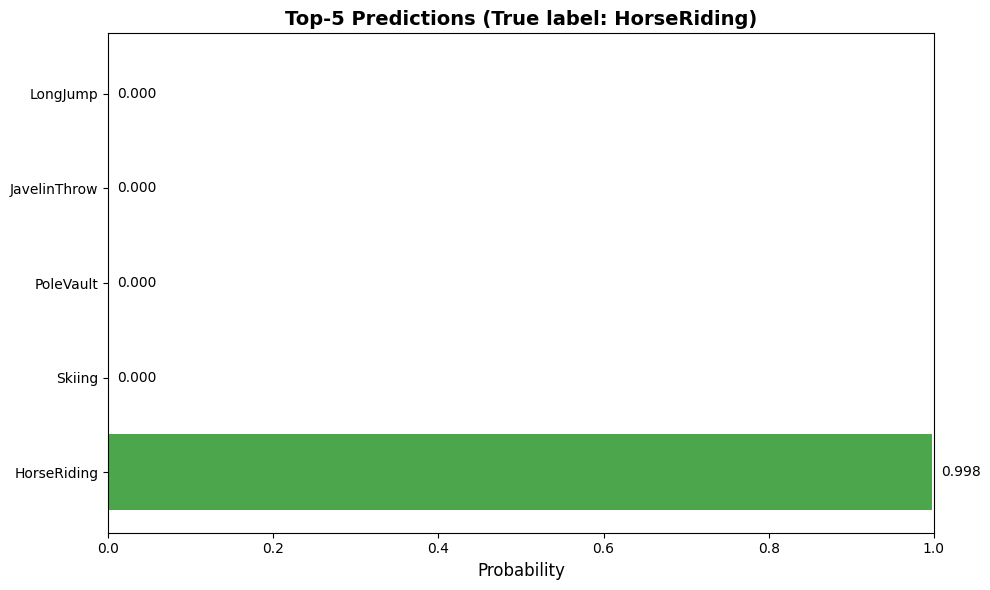

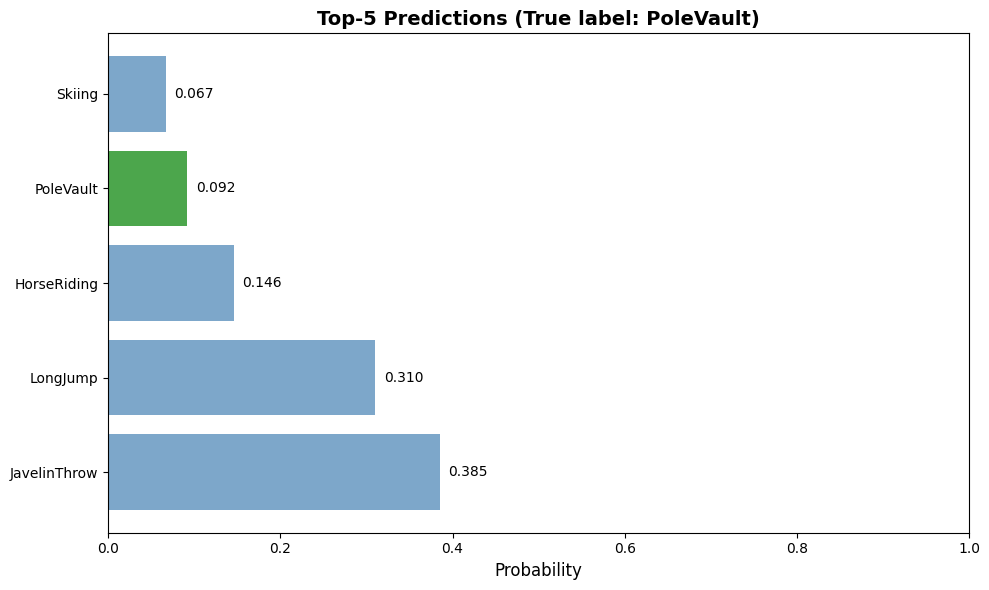

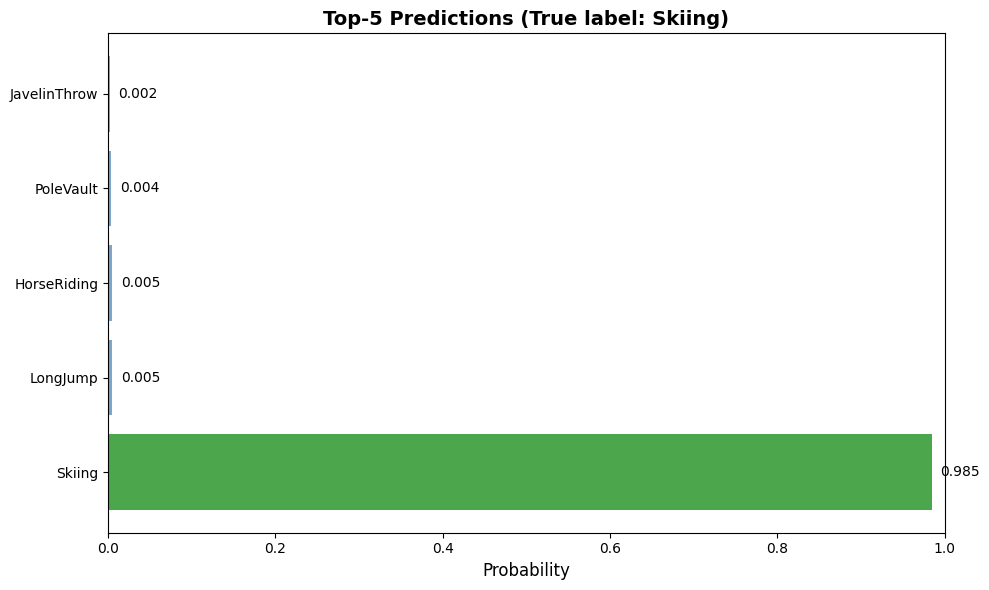

✅ Evaluation complete!


In [19]:
# Visualize some predictions
import random

for i in range(3):
    idx = random.randint(0, len(test_results['predictions'])-1)
    
    # Get prediction and true label
    pred = test_results['predictions'][idx]
    true_label = test_results['labels'][idx]
    probs = test_results['probabilities'][idx]
    
    # Plot top-k predictions
    plot_top_k_predictions(
        probs, true_label, class_names, k=5
    )

print("✅ Evaluation complete!")

## Summary

✅ Model evaluation completed!
✅ Visualizations saved!

**Next**: Use `04_inference_and_prediction.ipynb` for inference on new videos.